# Link Prediction in NetworKit

## Setup

In [48]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random

In [49]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


## Choose graph

In [50]:
#testGraph, trainingGraph = linkprediction.readGraph("input/twitter_combined.edgelist", 0.3)
testGraph = readGraph("input/CA-CondMat.edgelist", Format.SNAP)

In [51]:
#for u, v in testGraph.edges():
#    trainingGraph.removeEdge(u, v)
#trainingGraph.numberOfEdges()

In [52]:
#properties.overview(trainingGraph)

## Create training and test set

In [53]:
trainingGraph = linkprediction.TrainingGraphGenerator.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 65447 / 93497


In [54]:
missingLinks = linkprediction.UnconnectedNodesFinder(trainingGraph).findAll(2)
print("2-hop missing links in training graph:", len(missingLinks))

2-hop missing links in training graph: 770106


## Create link predictor instances

In [55]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [56]:
linkPredictors = (commonNeighborsIndex, preferentialAttachmentIndex, jaccardIndex, adamicAdarIndex, uDegreeIndex, vDegreeIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [57]:
positiveInstances = trainingGraph.randomEdges(25000)
negativeInstances = []
while len(negativeInstances) < 25000:
    u = trainingGraph.randomNode()
    v = trainingGraph.randomNode()
    if (u != v and not (testGraph.hasEdge(u, v) or testGraph.hasEdge(u, v)) and not (trainingGraph.hasEdge(u, v) or trainingGraph.hasEdge(u, v))):
        negativeInstances.append((u, v))
allInstances = positiveInstances + negativeInstances
random.shuffle(allInstances)
allInstances = np.array(allInstances)

nodePairsTrain = allInstances[:40000]
nodePairsTest = allInstances[-10000:]
classesTest = linkprediction.getClasses(nodePairsTest, trainingGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

In [58]:
#allMissing = []
#for i in range(0, trainingGraph.numberOfNodes()):
#    for j in range(i + 1, trainingGraph.numberOfNodes()):
#        if not trainingGraph.hasEdge(i, j) and not trainingGraph.hasEdge(j, i):
#            allMissing.append((i, j))

## Evaluation

In [59]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [60]:
dtc = ensemble.AdaBoostClassifier()
linkprediction.trainClassifier(nodePairsTrain, trainingGraph, dtc, *linkPredictors)

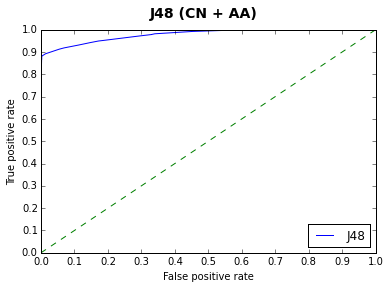

In [61]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [62]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.97798148087330683

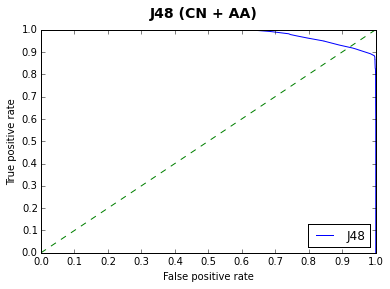

In [95]:
fpr, tpr, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [97]:
metrics.precision_recall_fscore_support(classesTest, isEdgePred)

ValueError: Can't handle mix of binary and continuous

In [63]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.5351264476776123 seconds


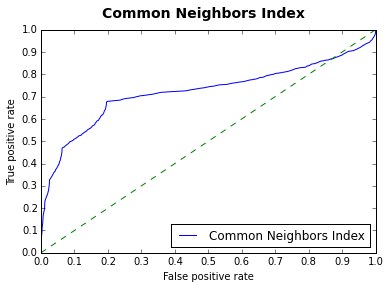

In [64]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Common Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [65]:
roc.getAreaUnderCurve()

0.72240095827186

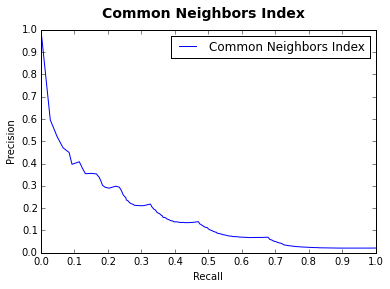

In [66]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Common Neighbors Index")
plt.legend(handles=[curve])

In [67]:
pr.getAreaUnderCurve()

0.1716522221880599

In [68]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.9460546970367432 seconds


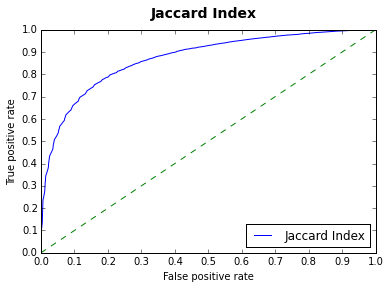

In [69]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Jaccard Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [70]:
roc.getAreaUnderCurve()

0.8715667862782605

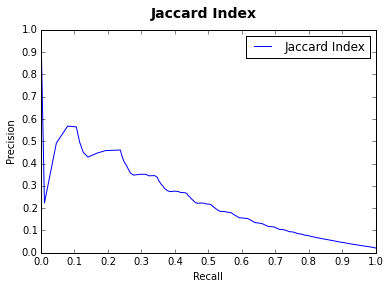

In [71]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Jaccard Index")
plt.legend(handles=[curve])

In [72]:
pr.getAreaUnderCurve()

0.24239184935593638

In [73]:
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.3720684051513672 seconds


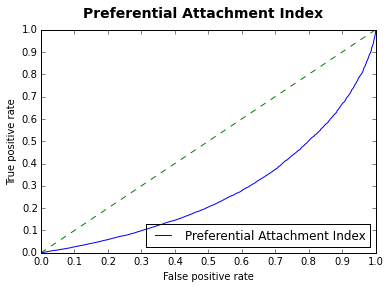

In [74]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [75]:
roc.getAreaUnderCurve()

0.28058094946807144

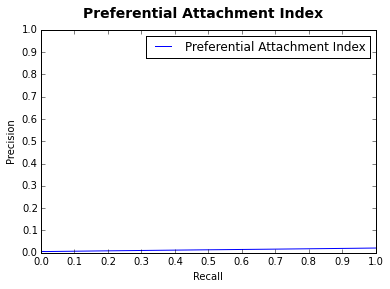

In [76]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.legend(handles=[curve])

In [77]:
pr.getAreaUnderCurve()

0.013560619229499036

In [78]:
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.6236264705657959 seconds


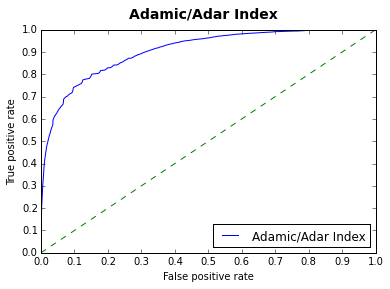

In [79]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [80]:
roc.getAreaUnderCurve()

0.9059537470584553

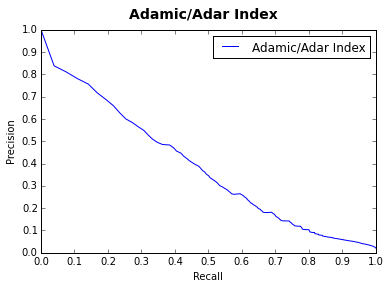

In [81]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.legend(handles=[curve])

In [82]:
pr.getAreaUnderCurve()

0.3862249453065731

In [83]:
#node = trainingGraph.randomNode()
#nodes = trainingGraph.neighbors(node)
#subGraph = graph.Subgraph().fromNodes(trainingGraph, nodes)

In [84]:
#LIST_LENGTH = len(nodes) - 1
#a = []
#color = {}
#while len(a) < LIST_LENGTH:
#    a.append(500)
#for e in nodes:
#    color[e] = len(nodes)
#a.append(2000)
#len(color)
#color[list(color)[-1]] = len(nodes) / 2
#color[list(color)[-2]] = len(nodes) / 3

In [85]:
#viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [86]:
startTime = time.time()
predictions = katzIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

232.64112877845764 seconds


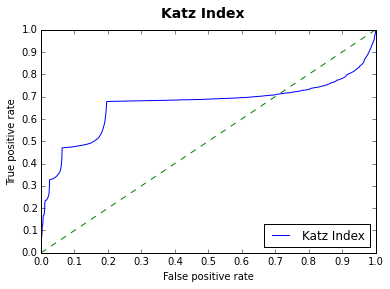

In [91]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [92]:
roc.getAreaUnderCurve()

0.6631722801680766

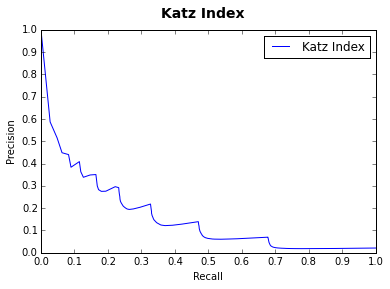

In [93]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.legend(handles=[curve])

In [94]:
pr.getAreaUnderCurve()

0.15788142827622684